In [177]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [178]:
import sys
sys.path.append('/Users/gsinyakov/ts_course_summer/')

In [179]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D

In [180]:
from load_dataset import Dataset
dataset = Dataset('../data/dataset/')

### Предсказание одномерного ряда на одну точку вперед

#### Выгрузим одномерный ряд alcohol_sales 

In [181]:
ts = dataset['alcohol_sales.csv']

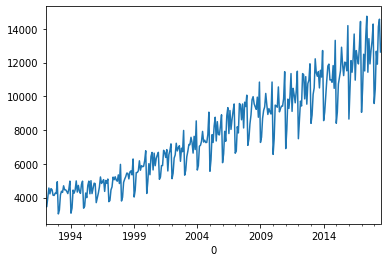

In [182]:
ts.plot()

#### Напишем функцию, которая переводит time series в матрицу обьекты-признаки

In [183]:
def transform_into_matrix(ts: pd.Series, num_lags: int) -> pd.DataFrame:
    """
    Transforms time series into lags matrix to allow
    applying supervised learning algorithms

    Parameters
    ------------
    ts
        Time series to transform
    num_lags
        Number of lags to use

    Returns
    --------
        train, test: np.arrays of shapes (ts-num_lags, num_lags), (num_lags,)
    """

    ts_values = ts.values
    data = {}
    for i in range(num_lags + 1):
        data[f'lag_{num_lags - i}'] = np.roll(ts_values, -i)

    lags_matrix = pd.DataFrame(data)[:-num_lags]
    lags_matrix.index = ts.index[num_lags:]

    return lags_matrix.drop('lag_0', axis=1).values, lags_matrix['lag_0'].values

In [184]:
NUM_LAGS = 48
X, y = transform_into_matrix(ts, NUM_LAGS)

#### Сделаем необходимый reshape к двумерному виду для сверточного слоя и разобьем на train, test 

In [185]:
X = X.reshape((X.shape[0], X.shape[1], 1))

split_idx = int(len(ts) * 0.7)
X_train, y_train = X[:split_idx], y[:split_idx]
X_test, y_test = X[split_idx:], y[split_idx:]

In [186]:
X[0]

array([[3459],
       [3458],
       [4002],
       [4564],
       [4221],
       [4529],
       [4466],
       [4137],
       [4126],
       [4259],
       [4240],
       [4936],
       [3031],
       [3261],
       [4160],
       [4377],
       [4307],
       [4696],
       [4458],
       [4457],
       [4364],
       [4236],
       [4500],
       [4974],
       [3075],
       [3377],
       [4443],
       [4261],
       [4460],
       [4985],
       [4324],
       [4719],
       [4374],
       [4248],
       [4784],
       [4971],
       [3370],
       [3484],
       [4269],
       [3994],
       [4715],
       [4974],
       [4223],
       [5000],
       [4235],
       [4554],
       [4851],
       [4826]])

In [187]:
y[0]

3699

#### Зададим входной сверточный слой модели.

In [188]:
model = Sequential()

In [189]:
### Обратим внимание на то, что для временных рядов используется свертка только в одном направлении по временной
### шкале - поэтому Conv1D
model.add(Conv1D(64, 2, activation='relu', input_shape=(NUM_LAGS, 1)))

#### Добавим Pooling для борьбы с переобучением (наличие/отсутствие пулинга как и выбор его типа опционален и зависит от длины вашего ряда, сложности паттерна и т.д., что влияет на переобучение вашей модели) 

In [190]:
model.add(MaxPooling1D())

#### Добавим слой Flatten для перехода к одномерному формату входных данных для полносвязной сети

In [191]:
model.add(Flatten())

#### Добавим пару промежуточных полносвязных слоев и выходной слой с одним нейроном для предсказания одной точки

In [192]:
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='relu'))

In [193]:
model.compile(optimizer='adam', loss='mse')

In [194]:
model.fit(X_train, y_train, epochs=400, verbose=0)

In [195]:
y_pred = model.predict(X_test).flatten()

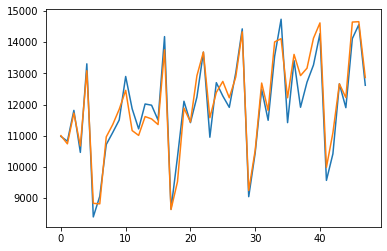

In [196]:
pd.Series(y_test).plot()
pd.Series(y_pred).plot()

### Векторное предсказание для одномерного ряда

Попробуем решить аналогичную предыдущему занятию задачу предсказания вектора следующих точек, но теперь добавим
в модель признаки, сгенерённые сверточным слоем 

#### 1) Возьмем функцию трансформации ряда из прошлого занятия

In [197]:
from typing import Tuple

def transform_ts_into_matrix(ts: pd.Series, num_lags_in: int, num_lags_out: int) -> Tuple[np.array, np.array]:
    """
    Данная функция должна пройтись скользящим окном по временному ряду и для каждых
    num_lags_in точек в качестве признаков собрать num_lags_out следующих точек в качестве таргета.
    
    Вернуть два np.array массива из X_train и y_train соответственно
    """
    sequence = ts.values
    X, y = list(), list()
    i = 0
    outer_idx = num_lags_out
    while outer_idx < len(sequence):
        inner_idx = i + num_lags_in
        outer_idx = inner_idx + num_lags_out
        X_, y_ = sequence[i:inner_idx], sequence[inner_idx:outer_idx]
        X.append(X_)
        y.append(y_)
        i += 1
    return np.array(X), np.array(y)

#### 2) Приведем входные данные к двумерному виду

In [198]:
NUM_LAGS = 24
NUM_OUTPUT = 12
X, y = transform_ts_into_matrix(ts, NUM_LAGS, NUM_OUTPUT)
X = X.reshape((X.shape[0], X.shape[1], 1))

#### 3) Разобьем на трейн и тест, отложив в качестве теста последние 12 точек

In [199]:
X_train, y_train = X[:-1], y[:-1]
X_test, y_test = X[[-1]], y[-1]

#### 4) Постройте сеть из CNN слоев, соединенных с полносвязными слоями 

In [200]:
# ваш код здесь
model = Sequential()
model.add(Conv1D(64, 2, activation='relu', input_shape=(NUM_LAGS, 1)))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(NUM_OUTPUT))
model.compile(optimizer='adam', loss='mse')

#### 5) Обучите модель

In [201]:
# ваш код здесь
model.fit(X_train, y_train, epochs=700, verbose=0)

#### 5) Постройте предсказания

In [202]:
y_pred = model.predict(X_test).flatten()

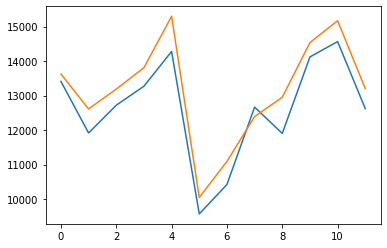

In [203]:
pd.Series(y_test).plot()
pd.Series(y_pred).plot()

#### 6) Постройте предсказание без добавления сверточных слоев и сравните качество

In [204]:
# ваш код здесь
X, y = transform_ts_into_matrix(ts, NUM_LAGS, NUM_OUTPUT)
X_train, y_train = X[:-1], y[:-1]
X_test, y_test = X[[-1]], y[-1]

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=NUM_LAGS))
model.add(Dense(32, activation='relu'))
model.add(Dense(NUM_OUTPUT))
model.compile(optimizer='adam', loss='mse')

In [205]:
# ваш код здесь
model.fit(X_train, y_train, epochs=700, verbose=0)

In [206]:
y_pred = model.predict(X_test).flatten()

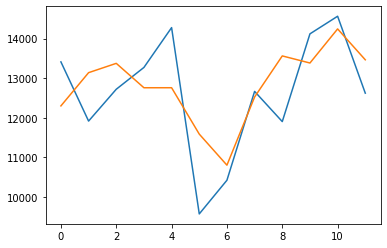

In [207]:
pd.Series(y_test).plot()
pd.Series(y_pred).plot()

### Предсказание многомерного ряда

Где применение CNN вызывает наибольший интерес, так это в многомерных рядах или рядах с наличием экзогенных признаков, так как позволяет автоматически генерировать большое количество признаков из коррелирующих рядов.

В данном примере мы будем предсказывать каждую компоненту многомерного временного ряда, используя данные из всех компонент, т.е. каждая компонента будет в качестве признаков лаги всех соседних рядов, а CNN будет вычленять из них произвольные признаки.

In [311]:
ts = pd.read_csv('../data/stability_index.csv', index_col='timestamp', parse_dates=True)

In [312]:
ts.head()

,1,2,3,4,5,6,7,8,9
timestamp,,,,,,,,,
2020-01-15 13:00:00,205.0,92.0,63.0,55.0,26.0,27.0,20.0,34.0,155.0
2020-01-15 14:00:00,173.0,97.0,69.0,44.0,31.0,22.0,41.0,26.0,182.0
2020-01-15 15:00:00,145.0,83.0,73.0,58.0,40.0,25.0,31.0,19.0,167.0
2020-01-15 16:00:00,84.0,60.0,53.0,39.0,32.0,31.0,19.0,15.0,102.0
2020-01-15 17:00:00,117.0,77.0,40.0,53.0,33.0,29.0,21.0,30.0,160.0


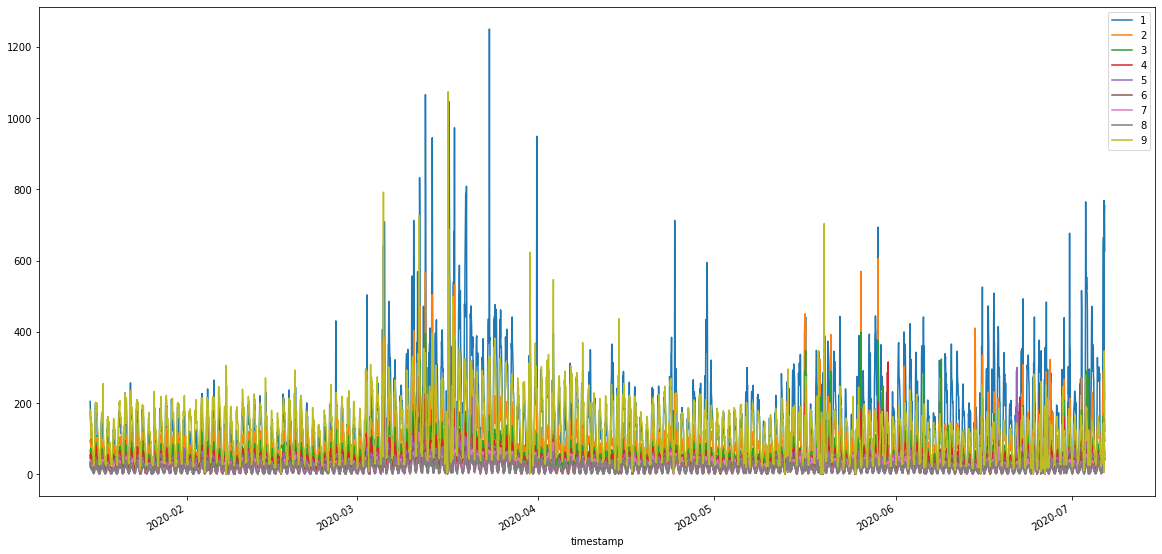

In [313]:
ts.plot(figsize=(20, 10))

In [314]:
ts.fillna(ts.median(), inplace=True)

#### 1) Возьмем функцию из предыдущего занятия (исключая метод flaten в конце, так как CNN принимает как раз 2D данные)

In [338]:
def transform_multi_ts_into_matrix(ts: pd.DataFrame, num_lags: int):
    """
    Данная функция должна пройтись скользящим окном по временному ряду
    и собрать в качестве признаков X np.array размерности (len(ts)-num_lags, n_dims, num_lags),
    а в качестве y np.array размерности (len(ts)-num_lags, n_dims),
    где n_dims - размерность многомерного ряда.
    
    То есть для всех компонент временного ряда мы должны взять num_lags предыдущих точек каждой компонент
    в качестве признаков и все компоненты текущей точки в качестве target
    """
    sequence = ts.values
    X, y = list(), list()
    i = 0
    end_i = num_lags
    while end_i < len(sequence): 
        seq_x, seq_y = sequence[i:end_i], sequence[end_i]
        X.append(seq_x)
        y.append(seq_y)
        i += 1
        end_i = i + num_lags
    return np.array(X), np.array(y)

In [339]:
NUM_LAGS = 48
NUM_DIMS = ts.shape[1]

In [340]:
X, y = transform_multi_ts_into_matrix(ts, NUM_LAGS)

In [341]:
# Видим, что в качестве обьекта мы получаем матрицу, где количество строк равно количеству компонент нашего ряда
# а количество столбцов количеству лагов, которое мы берем для каждой из компонент
X[0]

array([[205.,  92.,  63.,  55.,  26.,  27.,  20.,  34., 155.],
       [173.,  97.,  69.,  44.,  31.,  22.,  41.,  26., 182.],
       [145.,  83.,  73.,  58.,  40.,  25.,  31.,  19., 167.],
       [ 84.,  60.,  53.,  39.,  32.,  31.,  19.,  15., 102.],
       [117.,  77.,  40.,  53.,  33.,  29.,  21.,  30., 160.],
       [112.,  59.,  66.,  50.,  24.,  29.,  19.,  23., 145.],
       [119.,  64.,  53.,  41.,  32.,  29.,  29.,  22., 140.],
       [105.,  44.,  44.,  42.,  28.,  19.,  27.,  11., 142.],
       [106.,  36.,  49.,  33.,  19.,  30.,  23.,  20., 115.],
       [ 72.,  46.,  32.,  26.,  15.,  25.,  20.,  17.,  85.],
       [ 61.,  32.,  23.,  14.,  15.,  19.,   9.,   8.,  69.],
       [ 53.,  26.,  13.,  21.,  11.,  12.,   6.,   6.,  55.],
       [ 32.,  21.,  11.,   9.,   6.,   7.,   5.,   7.,  58.],
       [ 16.,  23.,  11.,   5.,   9.,   6.,   9.,  11.,  30.],
       [ 23.,  13.,  13.,  12.,   2.,   4.,   5.,   3.,  24.],
       [ 19.,   9.,   7.,   7.,   6.,   6.,   3.,   3.,

In [342]:
y[0]

array([129.,  69.,  72.,  45.,  32.,  22.,  17.,  18., 171.])

#### 2) Разбейте на train/test

In [343]:
split_idx = int(len(ts)*0.9)

X_train, y_train = X[:split_idx], y[:split_idx]
X_test, y_test = X[split_idx:], y[split_idx:]

#### 3) Постройте сеть, со сверточным слоем и несколькими полносвязными в конце (подумайте какой shape входных и выходных данных должен быть у первого и последнего слоя)

In [344]:
# ваш код здесь
from keras.layers import Dropout


model = Sequential()
model.add(Conv1D(64, 4, activation='relu', input_shape=(NUM_LAGS, NUM_DIMS)))
model.add(Conv1D(64, 2, activation='relu', input_shape=(NUM_LAGS, NUM_DIMS)))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(NUM_DIMS))
model.compile(optimizer='adam', loss='mse')

#### 4) Обучите модель

In [345]:
# ваш код здесь
model.fit(X_train, y_train, epochs=500, verbose=0)

#### 5) Сделайте предсказание на тесте

In [346]:
# ваш код здесь
y_pred = model.predict(X_test)

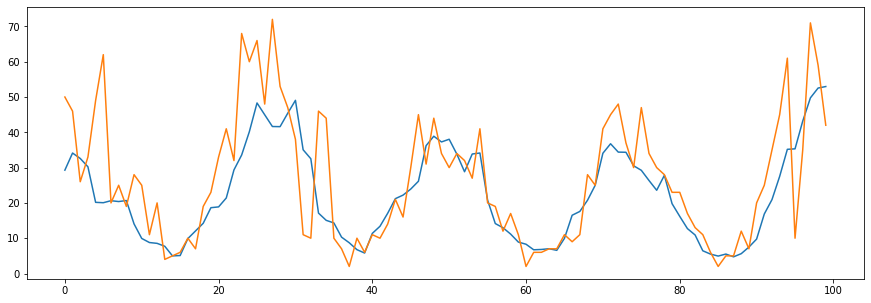

In [347]:
pd.Series(y_pred[:, 5][-100:]).plot(figsize=(15, 5))
pd.Series(y_test[:, 5][-100:]).plot(figsize=(15, 5))

#### 6) Сравните полученые предсказания с предсказанием каждой компоненты как отдельного ряда при помощи TimeSeriesPredictor

* Разбейте ряд на 9 одномерных рядов
* Обучите модель TimeSeriesPredictor
* Сделайте батч предсказание на длину X_test
* сравните результаты с CNN

In [182]:
# ваш код здесь

#### 7) Сделайте то же самое, что и в 6 пункте, но теперь добавьте в качестве признаков для каждого одномерного ряда лаги от всех остальных 8 рядов. Получился ли результат лучше чем CNN?

In [183]:
# ваш код здесь

array([169., 399., 383., ..., 730., 756., 627.])